In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp search

In [3]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd

In [4]:
#export
## temp while api is not aperational
# from food.clipmodel import *
from PIL import Image

In [5]:
# #export
# foods = read_sql('foods')
# # foods = foods.drop(columns = ['clip'])
# foods = foods.set_index('id')

In [6]:
#export
q = """select  i.food_id,f.description, f.category,f.energy,f.protein,f.carb,f.fat,i.clip,i.id 
               from food.foods_prompted_images_new i 
               join food.foods f on (f.id = i.food_id)"""
foods = pd.read_sql(q,engine).set_index('id')

In [7]:
foods

,food_id,description,category,energy,protein,carb,fat,clip
id,,,,,,,,
21,1097524,"Milk, lactose free, reduced fat (2%)","Milk, reduced fat",50.0,3.35,4.91,1.90,"[0.0379849, 0.08915244, 0.02751343, 0.03320773..."
22,1097524,"Milk, lactose free, reduced fat (2%)","Milk, reduced fat",50.0,3.35,4.91,1.90,"[0.049462415, 0.080735266, -0.011244243, 0.057..."
23,1097524,"Milk, lactose free, reduced fat (2%)","Milk, reduced fat",50.0,3.35,4.91,1.90,"[0.07059754, 0.1138613, 0.010621139, 0.0343210..."
24,1097524,"Milk, lactose free, reduced fat (2%)","Milk, reduced fat",50.0,3.35,4.91,1.90,"[0.06880593, 0.113496624, 0.0101010045, 0.0340..."
25,1097524,"Milk, lactose free, reduced fat (2%)","Milk, reduced fat",50.0,3.35,4.91,1.90,"[0.0708564, 0.11345326, 0.010549607, 0.0330047..."
...,...,...,...,...,...,...,...,...
104292,1104566,"Fluid replacement, 5% glucose in water",Sport and energy drinks,0.0,0.00,0.12,0.00,"[0.028362116, 0.086325265, 0.0057743993, 0.056..."
104293,1104566,"Fluid replacement, 5% glucose in water",Sport and energy drinks,0.0,0.00,0.12,0.00,"[0.024256386, 0.086113, -0.015549646, 0.034203..."
104294,1104570,"Fish fillet, fried as ingredient in sandwiches",Not included in a food category,200.0,18.11,8.18,10.03,"[-0.009084468, 0.062450767, 0.034620915, 0.020..."


In [8]:
def mean_vector(g):
    return series2tensor(g).mean(0).reshape(768).detach().clone()

In [9]:
#export
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)



In [10]:
#export
def search_image_(url=None,head = 1,env='dev'):
    client = dev_client if env == 'dev' else prod_client
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [11]:
#export
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [23]:
def mkurl(photo_id):
    return 'https://glovo.away.guru/photos_resized/'+photo_id
from food.search import *

In [16]:
#export
def multiple_foods(url,env='dev'):

    image_clip,selected = search_image_(url,head=100,env=env)
    # selected=selected[selected['category'].isin(selected_categories)]
    selected=selected.reset_index(drop=True)
    clip = series2tensor(selected['clip'])
    initscore = float(cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768)).detach().clone())
    startscore = initscore-0.0000001
    n=0

    while startscore !=initscore:
        startscore = initscore
        
        selected = selected.reset_index(drop=True)
        for i in reversed(selected.index):
            clip = series2tensor(selected['clip'])
            dropped = drop_vector(clip,i)
            testscore = float(cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768)).detach().clone())

            if testscore > initscore-0.0001: 
                r = selected.loc[i,'description']
                selected = selected.drop(i)
                initscore = testscore

            else:
                extra = multiply_vector(clip,i,1)
                testscore = float(cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768)).detach().clone())
                if testscore > initscore: 
                    selected = selected.append(selected.loc[i])
                    initscore = testscore

            n+=1
            if n ==15:break

        print(initscore)
    count = selected.groupby('description')['clip'].count().sort_index()
    r = selected.drop_duplicates('description').set_index("description").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['share'] = r['count'].cumsum()/r['count'].sum()

    description = '. '.join(r[r['share']<0.9].index.unique().tolist())


    return r.drop(columns = ['clip']), description, selected,initscore
    

In [17]:
#export
def search_image(url,env='dev'):
    r, desc, sel,score = multiple_foods(url,env=env)
    df = sel[['energy','protein','carb','fat','score']].mean().to_frame().T
    df['score'] =score
    df['description'] = desc
    return df


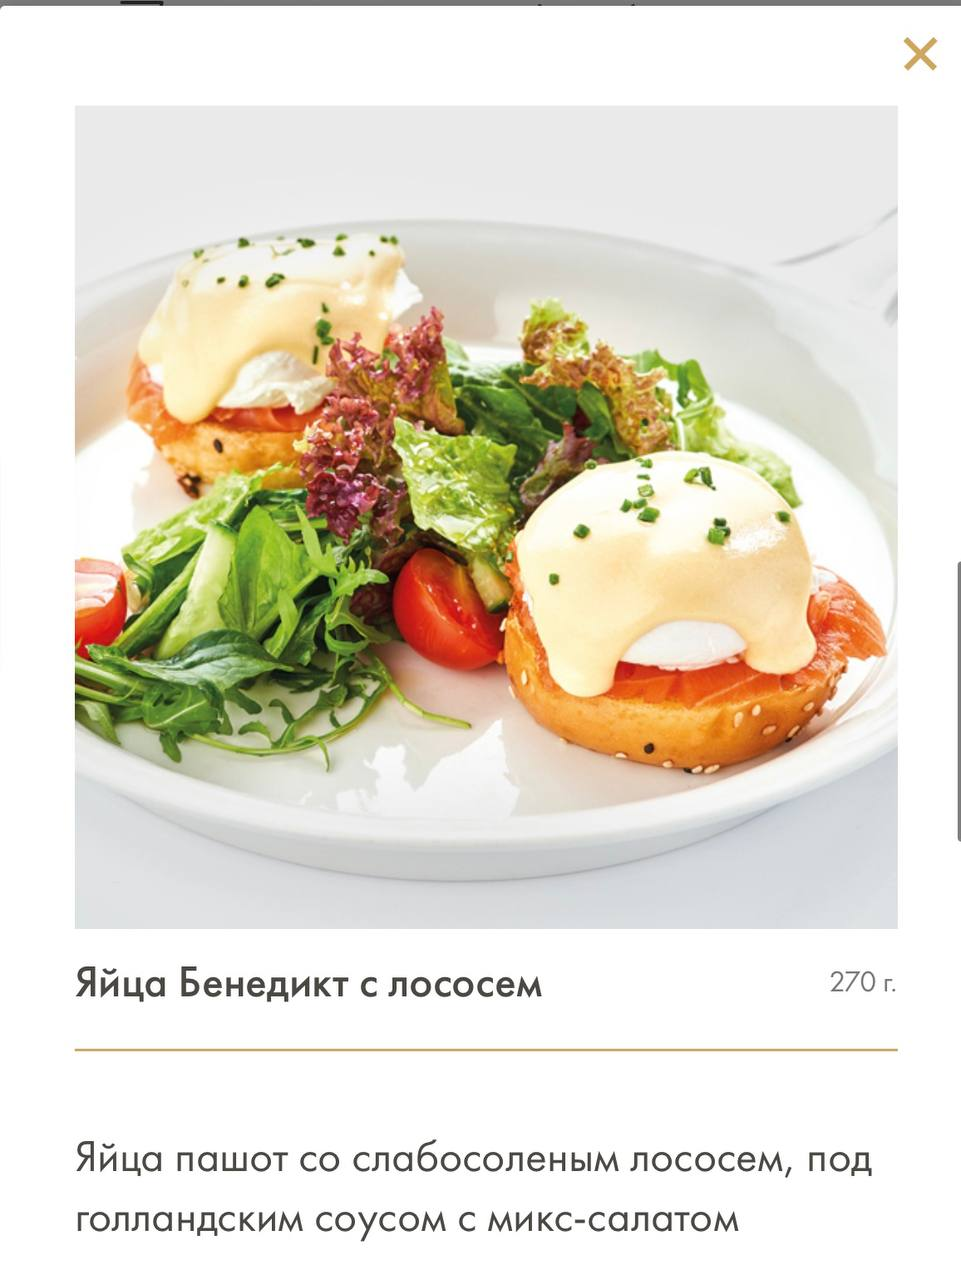

In [22]:
get_image_from_url(url)

In [27]:
!nbdev_build_lib

Converted 00_clipmodel.ipynb.
Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_progress_check.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_search_glovo.ipynb.
Converted 00_tools.ipynb.
Converted 01_multiple_foods.ipynb.
Converted 01_search.ipynb.
Converted 0_template copy 2.ipynb.
Converted 0_template copy 3.ipynb.
Converted 0_template copy.ipynb.
Converted 0_template.ipynb.
Converted aiogram_bot.ipynb.
Converted classifying_glovo_images.ipynb.
Converted foods_prompted_images_cleaning.ipynb.
Converted inference.ipynb.
Converted inference_food_categories.ipynb.
Converted inline_kb.ipynb.
Converted new_match_dataset.ipynb.
Converted recepie_scraper.ipynb.
Converted stats.ipynb.
Converted testset_exploration.ipynb.
Converted usda_parsing.ipynb.
